In [1]:
import pandas as pd
from collections import Counter
from pathlib import Path

INPUT_PATH = Path(f"/mnt/storage_dimm2/kaggle_data/commonlitreadabilityprize")
MODEL_CACHE = Path("/mnt/storage/model_cache/torch")

for child in INPUT_PATH.iterdir():
    print(child)

/mnt/storage_dimm2/kaggle_data/commonlitreadabilityprize/test.csv
/mnt/storage_dimm2/kaggle_data/commonlitreadabilityprize/sample_submission.csv
/mnt/storage_dimm2/kaggle_data/commonlitreadabilityprize/train.csv


In [2]:
df = pd.read_csv(INPUT_PATH / "train.csv")
df.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [3]:
df.describe()

,target,standard_error
count,2834.000000,2834.000000
mean,-0.959319,0.491435
std,1.033579,0.034818
min,-3.676268,0.000000
25%,-1.690320,0.468543
50%,-0.912190,0.484721
75%,-0.202540,0.506268
max,1.711390,0.649671


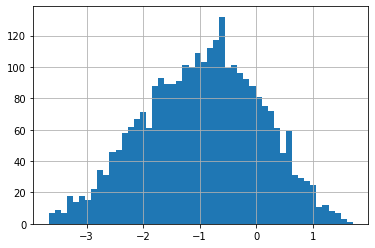

In [4]:
df["target"].hist(bins=50);

In [5]:
str(df.loc[0, "excerpt"])

'When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.\nThe floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.\nAt each end of the room, on the wall, hung a beautiful bear-skin rug.\nThese rugs were for prizes, one for the girls and one for the boys. And this was the game.\nThe girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.\nThis would have been an easy matter, but each traveller was obliged to wear snowshoes.'

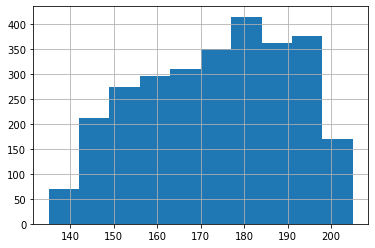

In [6]:
df["word_count"] = df['excerpt'].str.split().apply(len)
df["word_count"].hist();

# Huggingface

In [7]:
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
import torch

In [28]:
model_name = "roberta-base"

tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=MODEL_CACHE)
model = AutoModelForSequenceClassification.from_pretrained(model_name, cache_dir=MODEL_CACHE)

model.classifier.out_proj = torch.nn.Linear(model.classifier.out_proj.in_features, 1)

model

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [29]:
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
outputs = model(**inputs)

In [30]:
outputs["logits"]

tensor([[-0.1054]], grad_fn=<AddmmBackward>)

# Folds